# CMSS 25S Final Project 

## Title: Modeling the Mere Exposure Effect in Temporal Information Diffusion
## Group no. 35

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

#Load Data (network0–network3)
network_paths = {
    "network0": "network0.csv",
    "network1": "network1.csv",
    "network2": "network2.csv",
    "network3": "network3.csv"
}

def convert_to_temporal_edge_list(path):
    df = pd.read_csv(path)
    df_long = df.melt(id_vars=["TIME"], var_name="pair", value_name="value")
    df_long[["source", "target"]] = df_long["pair"].str.extract(r'P(\d+)_TO_P(\d+)', expand=True)
    df_long = df_long.dropna(subset=["source", "target"])
    df_long = df_long[df_long["value"] == 1]
    df_long["timestamp"] = (df_long["TIME"] * 3).astype(int)
    df_long["source"] = df_long["source"].astype(int)
    df_long["target"] = df_long["target"].astype(int)
    return df_long[["source", "target", "timestamp"]]

temporal_edge_lists = {name: convert_to_temporal_edge_list(path) for name, path in network_paths.items()}


### Original ver.

In [2]:
# Cascade Model Helpers
def build_contact_dict(df):
    contact_dict = defaultdict(list)
    for _, row in df.iterrows():
        contact_dict[row["target"]].append((row["source"], row["timestamp"]))
    return contact_dict

def shuffle_timestamps(df):
    shuffled = df.copy()
    shuffled["timestamp"] = np.random.permutation(shuffled["timestamp"].values)
    return shuffled

def simulate_fractional_threshold(contact_dict, theta, phi, seed, N):
    adopted = set([seed])
    adopted_time = {seed: 0}
    changed = True
    while changed:
        changed = False
        for node in contact_dict:
            if node in adopted:
                continue
            recent_contacts = [src for src, t in contact_dict[node]
                               if max(adopted_time.values()) - theta < t <= max(adopted_time.values())]
            if recent_contacts:
                frac = len([src for src in recent_contacts if src in adopted]) / len(set(recent_contacts))
                if frac >= phi:
                    adopted.add(node)
                    adopted_time[node] = max([t for src, t in contact_dict[node] if src in adopted])
                    changed = True
    return len(adopted) / N

def simulate_absolute_threshold(contact_dict, theta, phi_abs, seed, N):
    adopted = set([seed])
    adopted_time = {seed: 0}
    changed = True
    while changed:
        changed = False
        for node in contact_dict:
            if node in adopted:
                continue
            contacts = [src for src, t in contact_dict[node]
                        if max(adopted_time.values()) - theta < t <= max(adopted_time.values())]
            count = len([src for src in contacts if src in adopted])
            if count >= phi_abs:
                adopted.add(node)
                adopted_time[node] = max([t for src, t in contact_dict[node] if src in adopted])
                changed = True
    return len(adopted) / N



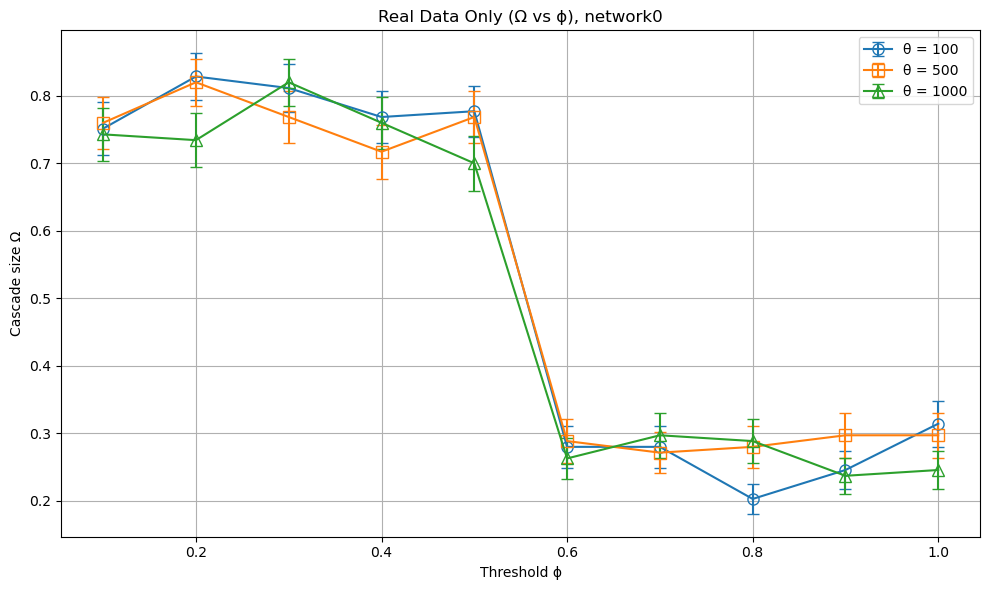

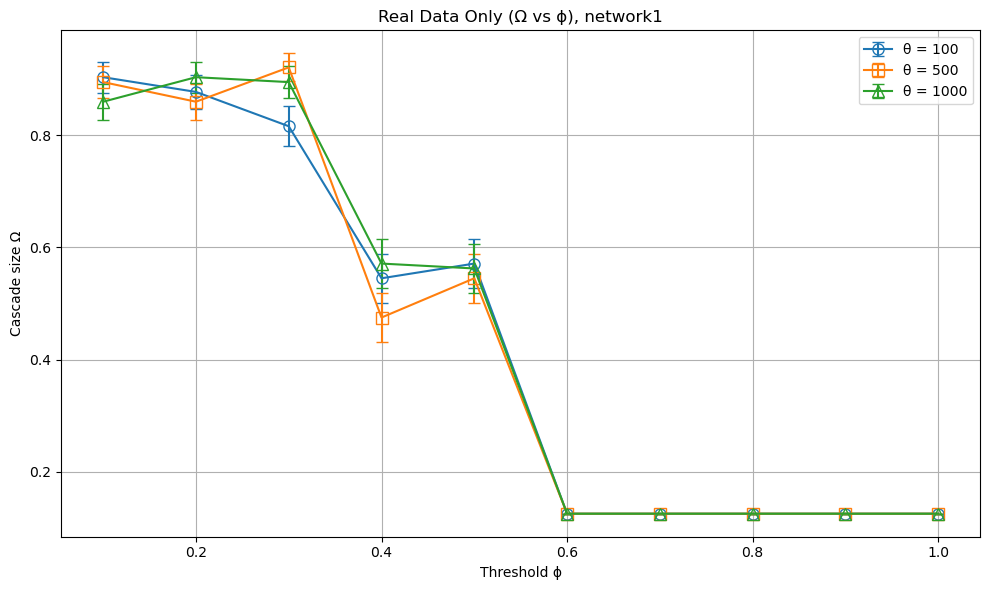

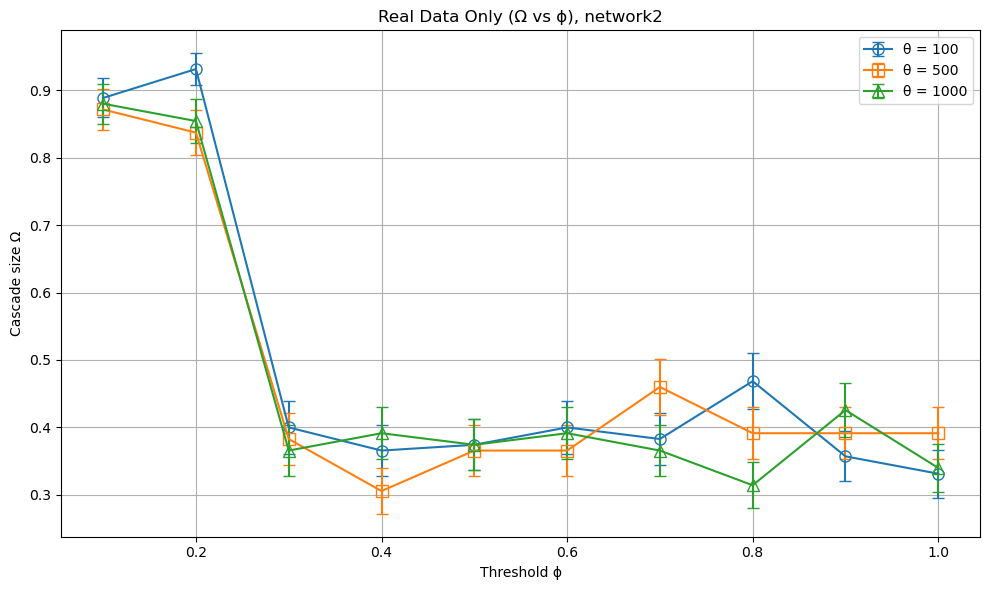

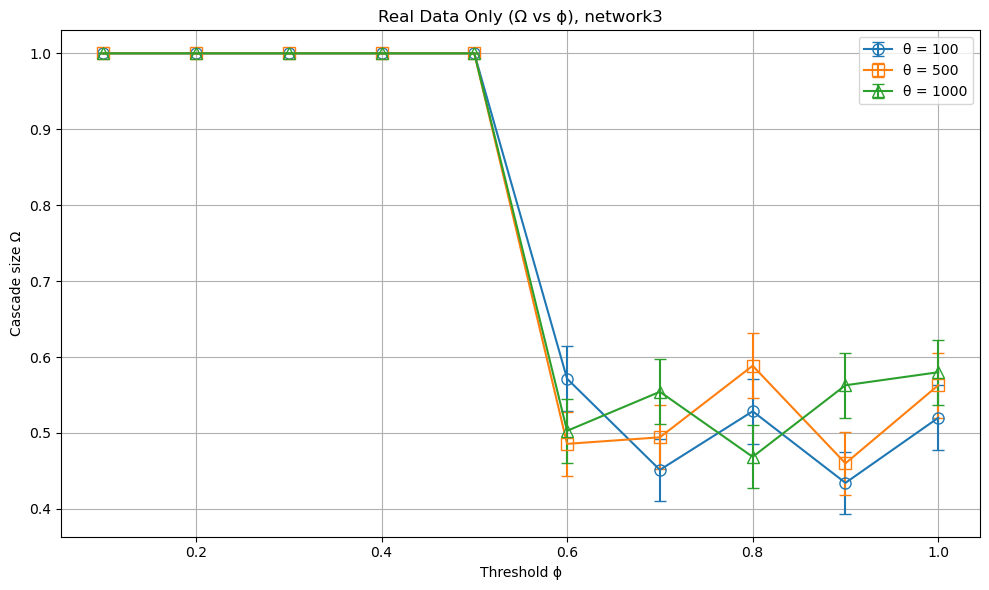

In [3]:
theta_values = [100, 500, 1000]
phi_values = np.round(np.linspace(0.1, 1.0, 10), 2)
repeats = 100
fig2_results = {}


for net_name, df in temporal_edge_lists.items():
    
    real_dict = build_contact_dict(df)
    N = len(set(df["source"]) | set(df["target"]))
    theta_result = {}

    for theta in theta_values:
        real_means, real_se = [], []
        for phi in phi_values:
            vals = [
                simulate_fractional_threshold(
                    real_dict, theta, phi, random.choice(list(real_dict.keys())), N
                )
                for _ in range(repeats)
            ]
            real_means.append(np.mean(vals))
            real_se.append(np.std(vals) / np.sqrt(repeats))
        theta_result[theta] = {"real_mean": real_means, "real_se": real_se}

    fig2_results[net_name] = theta_result

for net_name, theta_data in fig2_results.items():
    plt.figure(figsize=(10, 6))
    for i, theta in enumerate(theta_values):
        result = theta_data[theta]
        plt.errorbar(
            phi_values, result["real_mean"], yerr=result["real_se"],
            fmt=['o', 's', '^', 'D'][i] + '-', markersize=8,
            markerfacecolor='none',
            markeredgecolor=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'][i],
            color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'][i],
            capsize=4,
            label=f"θ = {theta}"
        )
    plt.xlabel("Threshold ϕ")
    plt.ylabel("Cascade size Ω")
    plt.title(f"Real Data Only (Ω vs ϕ), {net_name}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


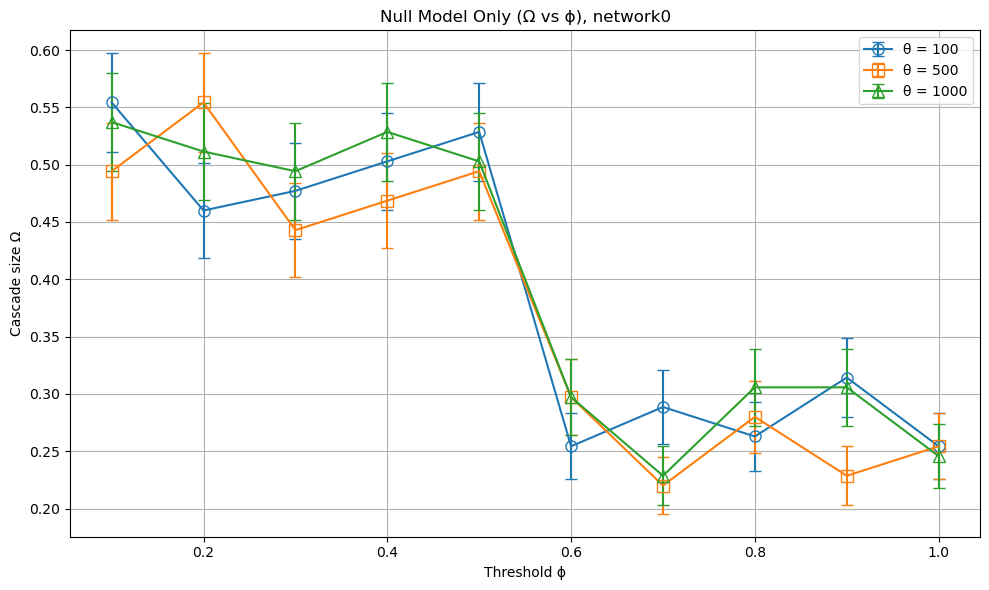

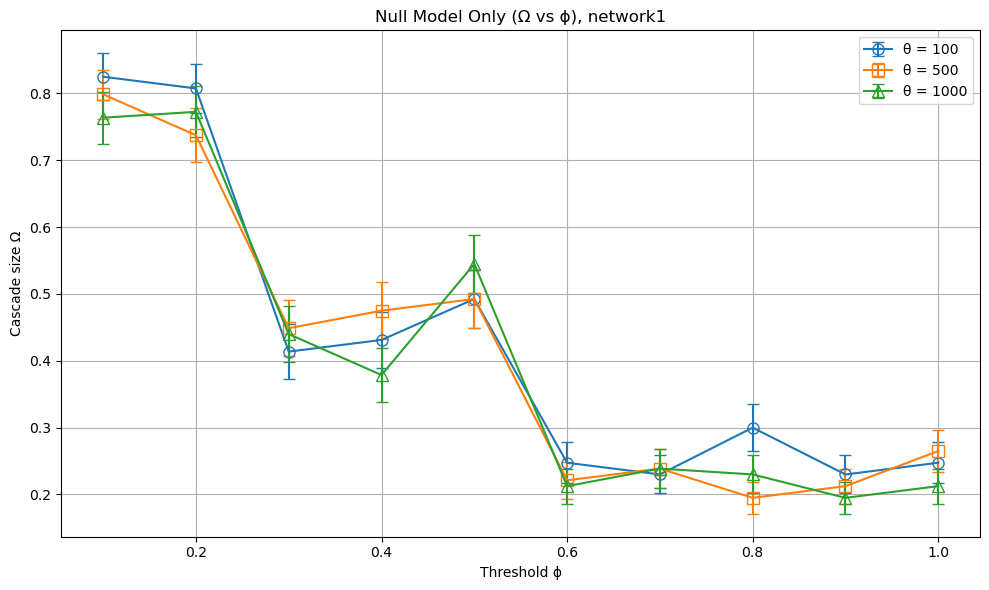

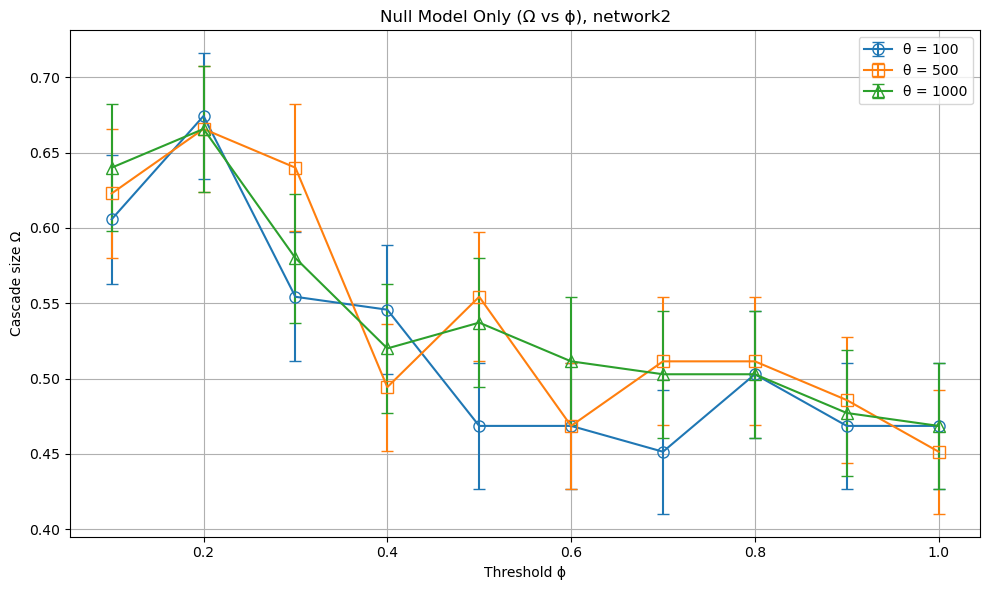

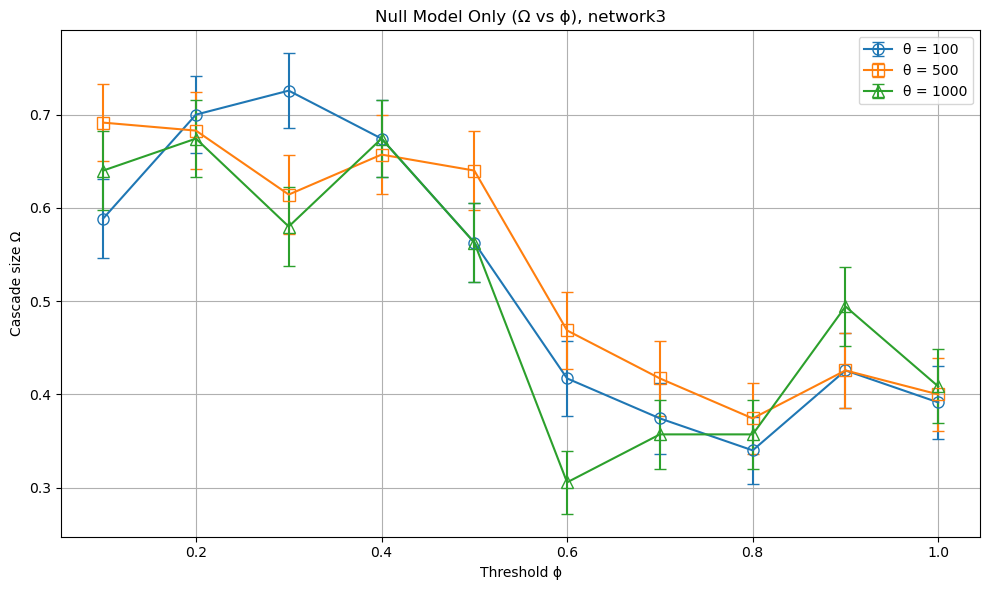

In [4]:
### 📊 Figure 2 – Ω vs ϕ for multiple θ (null only)
theta_values = [100, 500, 1000]
phi_values = np.round(np.linspace(0.1, 1.0, 10), 2)
repeats = 100
fig2_results = {}

for net_name, df in temporal_edge_lists.items():
    null_dict = build_contact_dict(shuffle_timestamps(df))
    N = len(set(df["source"]) | set(df["target"]))
    theta_result = {}

    for theta in theta_values:
        null_means, null_se = [], []
        for phi in phi_values:
            vals = [simulate_fractional_threshold(null_dict, theta, phi, random.choice(list(null_dict.keys())), N)
                    for _ in range(repeats)]
            null_means.append(np.mean(vals))
            null_se.append(np.std(vals) / np.sqrt(repeats))
        theta_result[theta] = {"null_mean": null_means, "null_se": null_se}

    fig2_results[net_name] = theta_result

for net_name, theta_data in fig2_results.items():
    plt.figure(figsize=(10, 6))
    for i, theta in enumerate(theta_values):
        result = theta_data[theta]
        plt.errorbar(
            phi_values, result["null_mean"], yerr=result["null_se"],
            fmt=['o', 's', '^', 'D'][i] + '-', markersize=8,
            markerfacecolor='none', markeredgecolor=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'][i],
            color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'][i],
            capsize=4, label=f"θ = {theta}"
        )
    plt.xlabel("Threshold ϕ")
    plt.ylabel("Cascade size Ω")
    plt.title(f"Null Model Only (Ω vs ϕ), {net_name}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



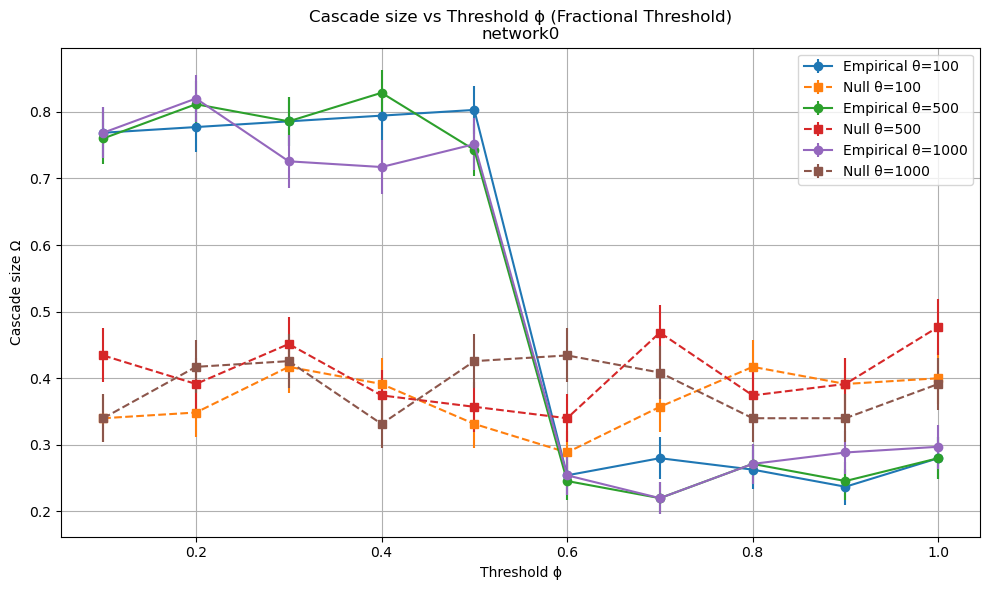

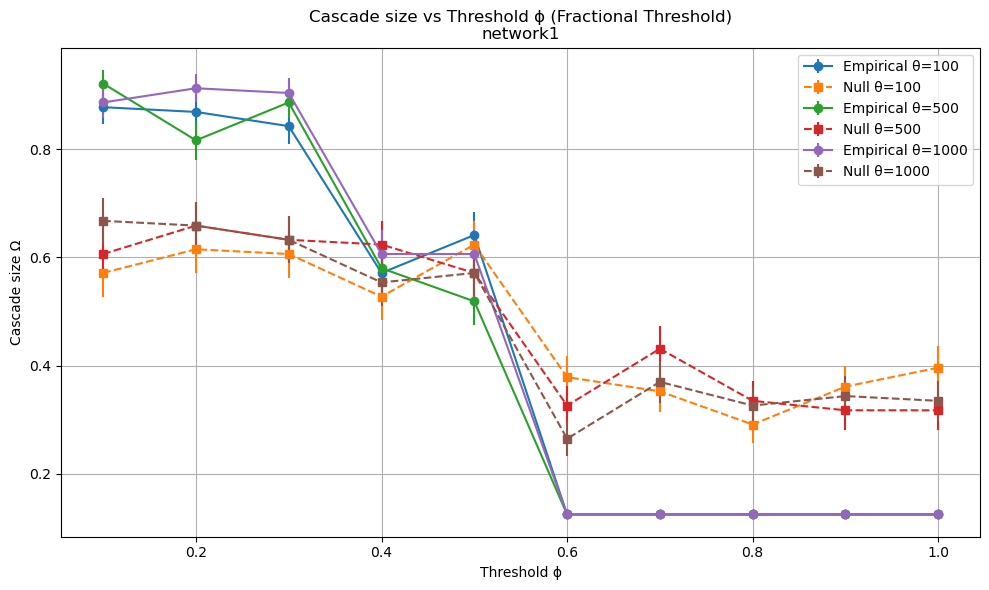

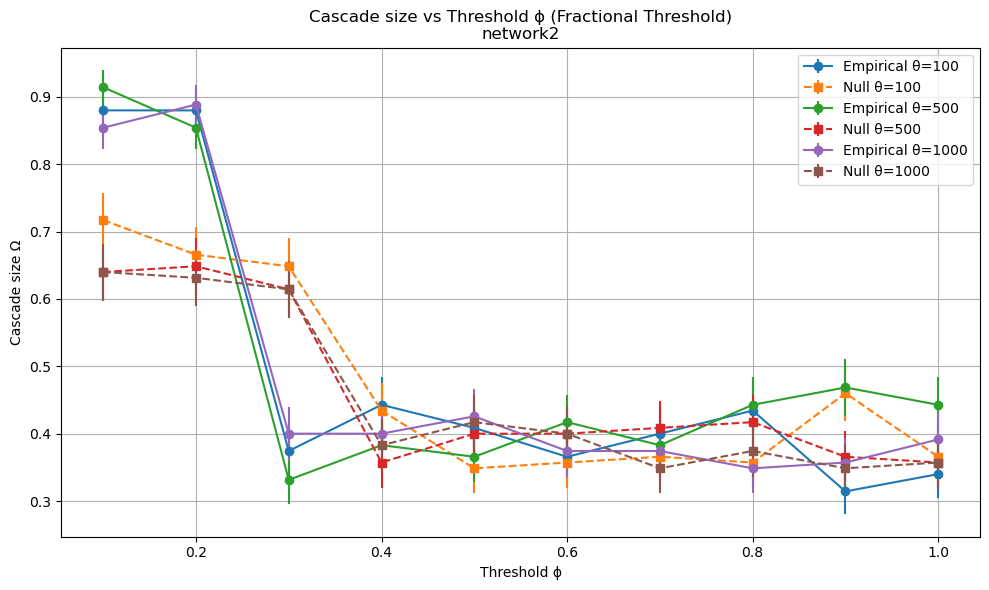

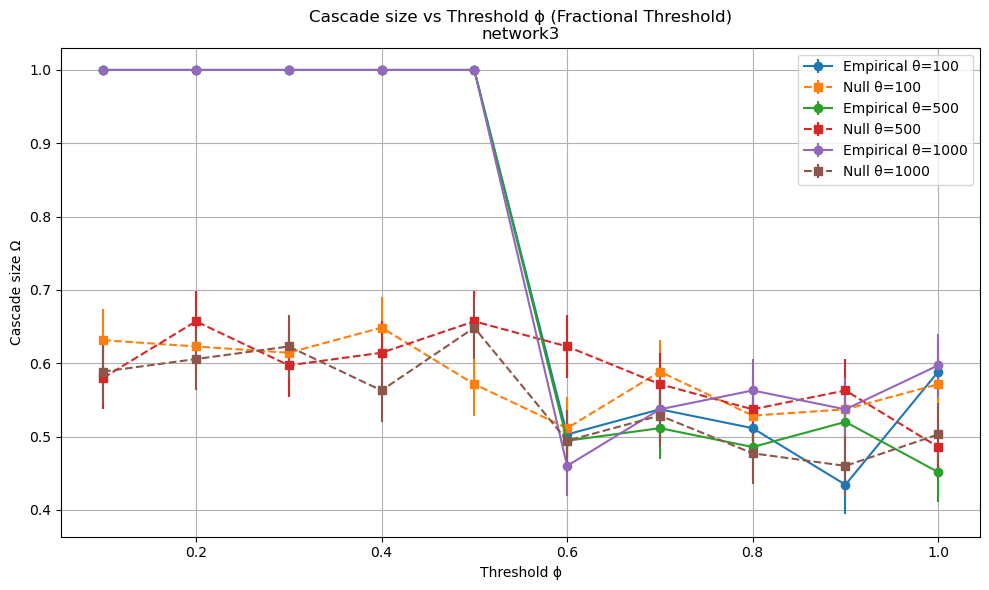

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random

theta_values = [100, 500, 1000]  
phi_values = np.round(np.linspace(0.1, 1.0, 10), 2)
repeats = 100

fig_phi_results_fractional = {}

for net_name, df in temporal_edge_lists.items():
    emp_dict = build_contact_dict(df)
    null_dict = build_contact_dict(shuffle_timestamps(df))
    N = len(set(df["source"]) | set(df["target"]))
    
    theta_result = {}
    
    for theta in theta_values:
        emp_means, emp_se = [], []
        null_means, null_se = [], []
        
        for phi in phi_values:
            emp_vals = [simulate_fractional_threshold(emp_dict, theta, phi, random.choice(list(emp_dict.keys())), N)
                        for _ in range(repeats)]
            null_vals = [simulate_fractional_threshold(null_dict, theta, phi, random.choice(list(null_dict.keys())), N)
                         for _ in range(repeats)]
            
            emp_means.append(np.mean(emp_vals))
            emp_se.append(np.std(emp_vals) / np.sqrt(repeats))
            null_means.append(np.mean(null_vals))
            null_se.append(np.std(null_vals) / np.sqrt(repeats))
        
        theta_result[theta] = {
            "phi": phi_values,
            "emp_mean": emp_means, "emp_se": emp_se,
            "null_mean": null_means, "null_se": null_se
        }
    
    fig_phi_results_fractional[net_name] = theta_result


for net_name, theta_data in fig_phi_results_fractional.items():
    plt.figure(figsize=(10, 6))
    for i, theta in enumerate(theta_values):
        data = theta_data[theta]
        plt.errorbar(data["phi"], data["emp_mean"], yerr=data["emp_se"],
                     fmt='o-', label=f"Empirical θ={theta}", markersize=6)
        plt.errorbar(data["phi"], data["null_mean"], yerr=data["null_se"],
                     fmt='s--', label=f"Null θ={theta}", markersize=6)
    plt.xlabel("Threshold ϕ")
    plt.ylabel("Cascade size Ω")
    plt.title(f"Cascade size vs Threshold ϕ (Fractional Threshold)\n{net_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


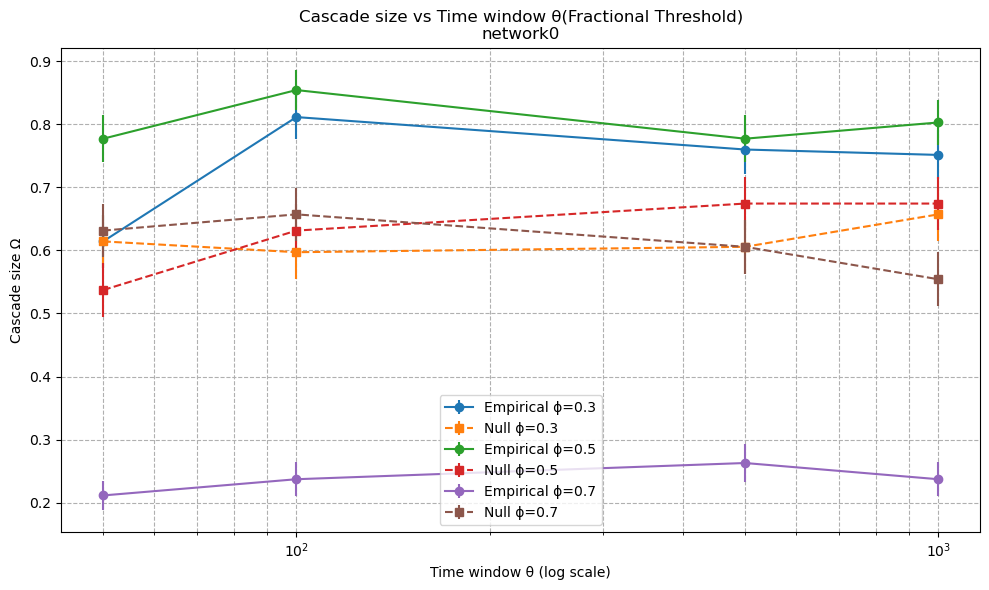

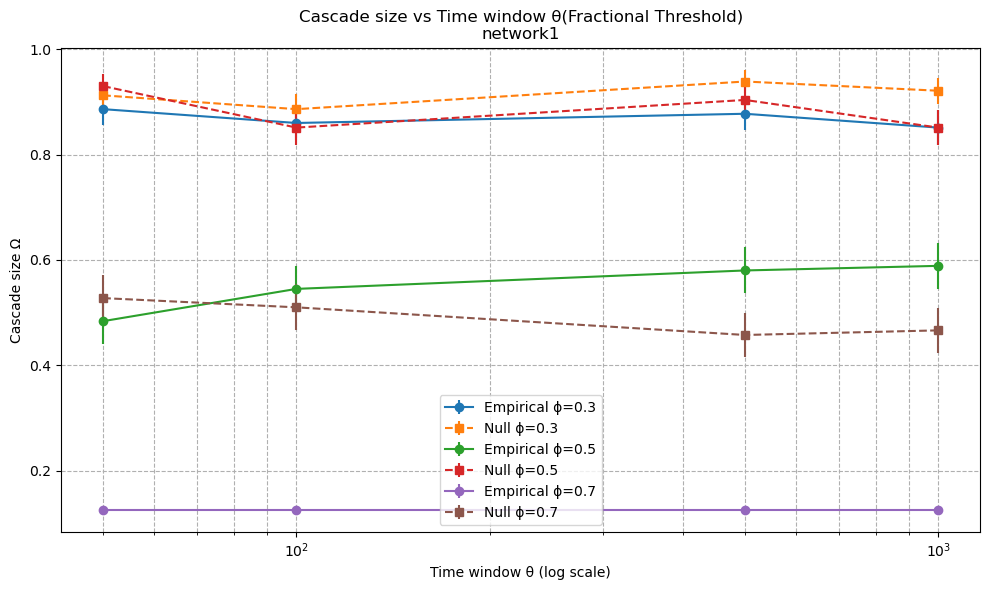

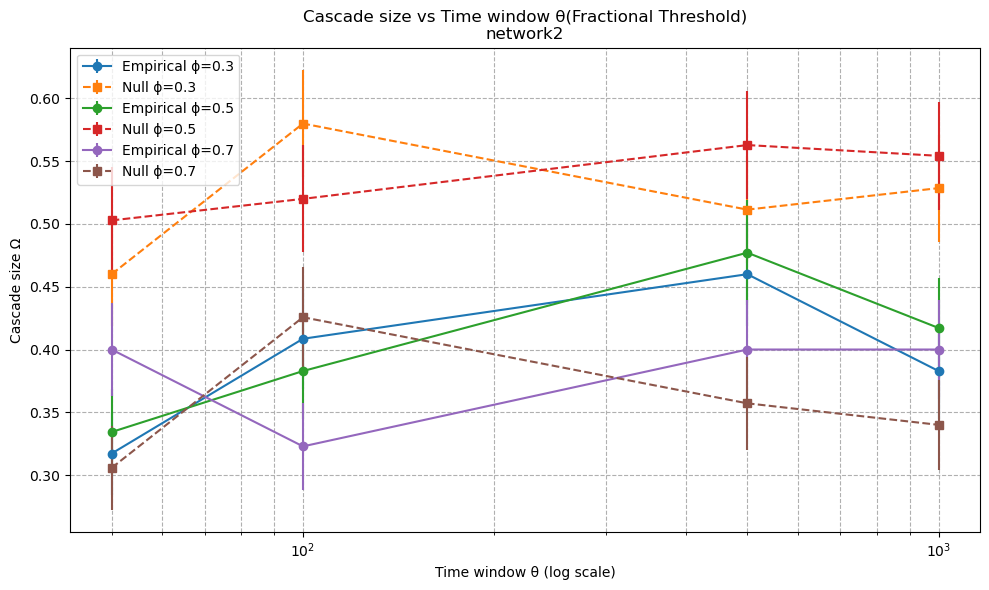

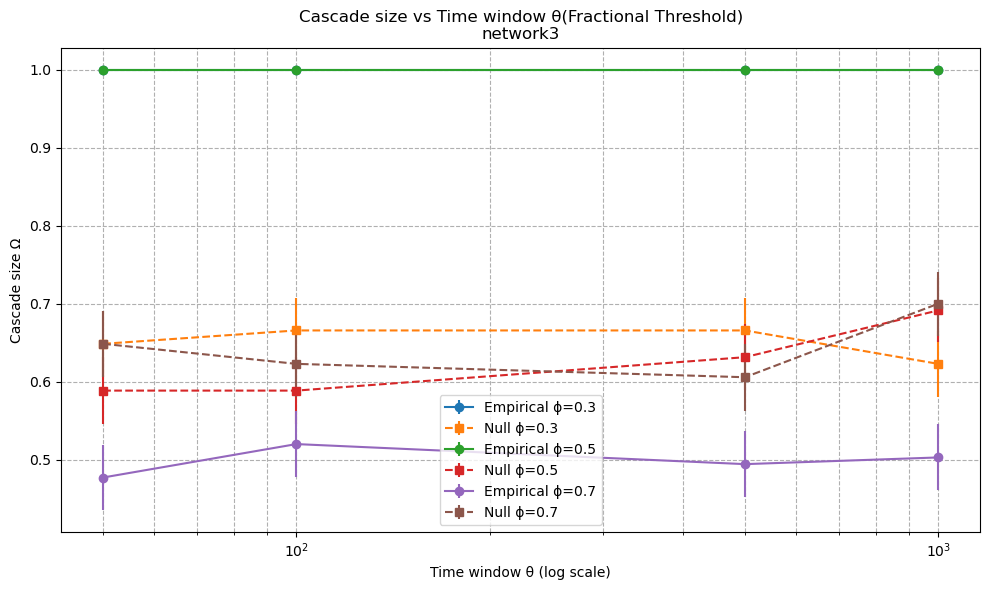

In [6]:
theta_values = np.array([50, 100, 500, 1000])
phi_values = [0.3, 0.5, 0.7]  
repeats = 100

fig_theta_results_frac = {}

for net_name, df in temporal_edge_lists.items():
    emp_dict = build_contact_dict(df)
    null_dict = build_contact_dict(shuffle_timestamps(df))
    N = len(set(df["source"]) | set(df["target"]))
    
    phi_result = {}
    
    for phi in phi_values:
        emp_means, emp_se = [], []
        null_means, null_se = [], []
        
        for theta in theta_values:
            emp_vals = [simulate_fractional_threshold(emp_dict, theta, phi, random.choice(list(emp_dict.keys())), N)
                        for _ in range(repeats)]
            null_vals = [simulate_fractional_threshold(null_dict, theta, phi, random.choice(list(null_dict.keys())), N)
                         for _ in range(repeats)]
            
            emp_means.append(np.mean(emp_vals))
            emp_se.append(np.std(emp_vals) / np.sqrt(repeats))
            null_means.append(np.mean(null_vals))
            null_se.append(np.std(null_vals) / np.sqrt(repeats))
        
        phi_result[phi] = {
            "theta": theta_values,
            "emp_mean": emp_means, "emp_se": emp_se,
            "null_mean": null_means, "null_se": null_se
        }
    
    fig_theta_results_frac[net_name] = phi_result


for net_name, phi_data in fig_theta_results_frac.items():
    plt.figure(figsize=(10, 6))
    for phi in phi_values:
        data = phi_data[phi]
        plt.errorbar(data["theta"], data["emp_mean"], yerr=data["emp_se"],
                     fmt='o-', label=f"Empirical ϕ={phi}", markersize=6)
        plt.errorbar(data["theta"], data["null_mean"], yerr=data["null_se"],
                     fmt='s--', label=f"Null ϕ={phi}", markersize=6)
    plt.xscale("log")
    plt.xlabel("Time window θ (log scale)")
    plt.ylabel("Cascade size Ω")
    plt.title(f"Cascade size vs Time window θ(Fractional Threshold)\n{net_name}")
    plt.legend()
    plt.grid(True, which="both", ls='--')
    plt.tight_layout()
    plt.show()


### Weighted ver.

In [7]:
def build_contact_dict(df):
    contact_dict = defaultdict(list)
    for _, row in df.iterrows():
        contact_dict[row["target"]].append((row["source"], row["timestamp"]))
    return contact_dict

def shuffle_timestamps(df):
    shuffled = df.copy()
    shuffled["timestamp"] = np.random.permutation(shuffled["timestamp"].values)
    return shuffled


def simulate_weighted_threshold(contact_dict, theta, phi, seed, N):
    adopted = set([seed])
    adopted_time = {seed: 0}
    changed = True

    while changed:
        changed = False
        for node in contact_dict:
            if node in adopted:
                continue

            
            current_time = max(adopted_time.values())

            
            window_contacts = [
                src for src, t in contact_dict[node]
                if current_time - theta < t <= current_time
            ]

            if not window_contacts:
                continue

            
            freq_all = defaultdict(int)
            freq_adopted = defaultdict(int)

            for src in window_contacts:
                freq_all[src] += 1
                if src in adopted:
                    freq_adopted[src] += 1

            
            total_weight = sum(freq_all.values())
            adopted_weight = sum(freq_adopted.values())

            frac = adopted_weight / total_weight if total_weight > 0 else 0

            if frac >= phi:
                adopted.add(node)
                adopted_time[node] = max(
                    [t for src, t in contact_dict[node] if src in adopted]
                )
                changed = True

    return len(adopted) / N


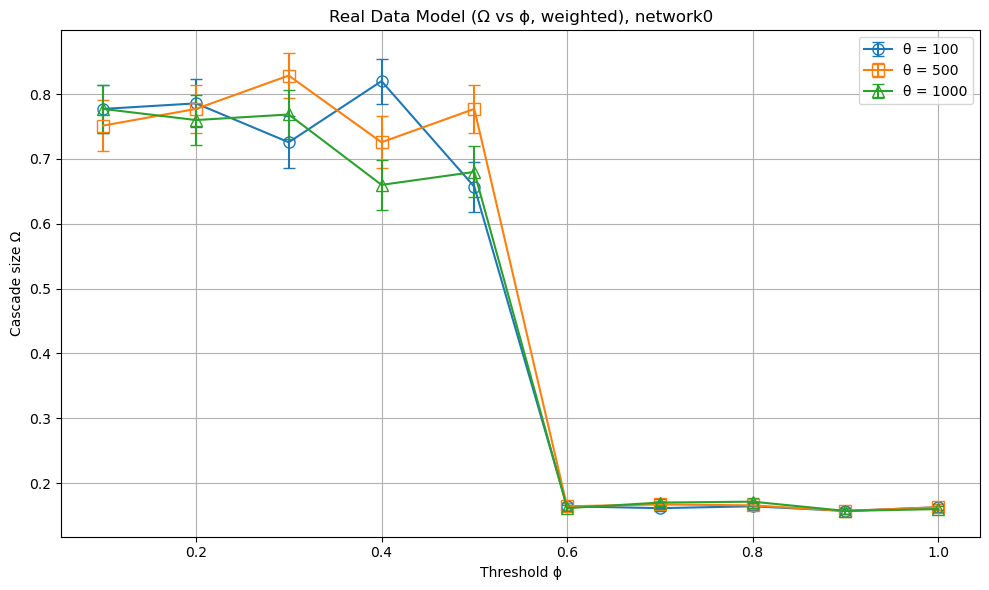

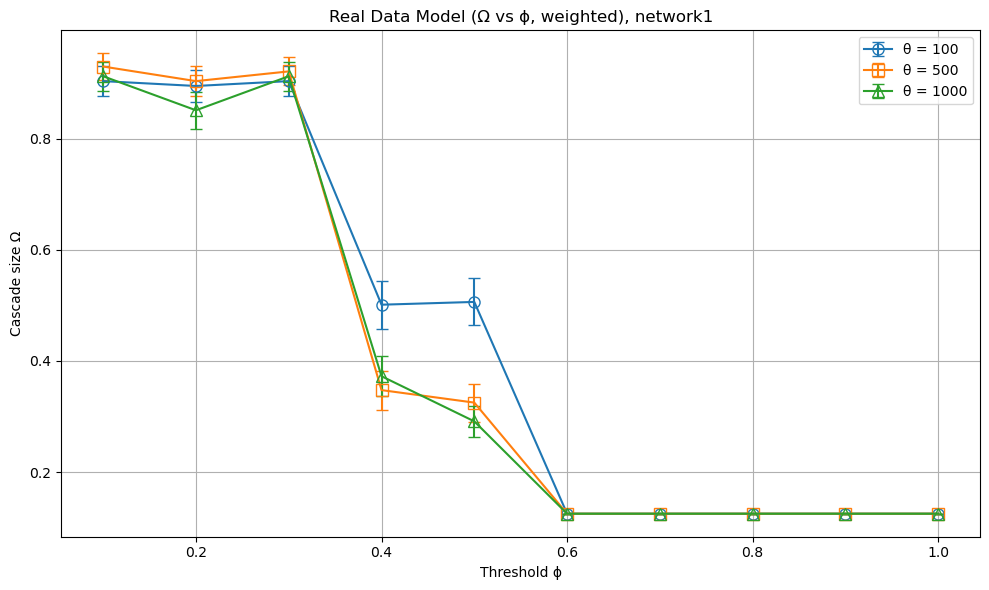

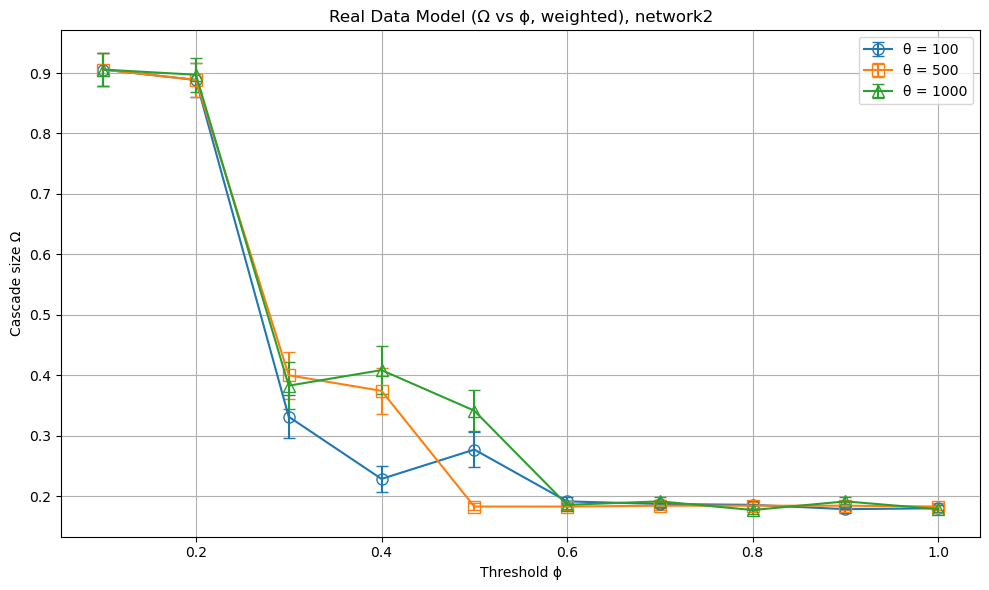

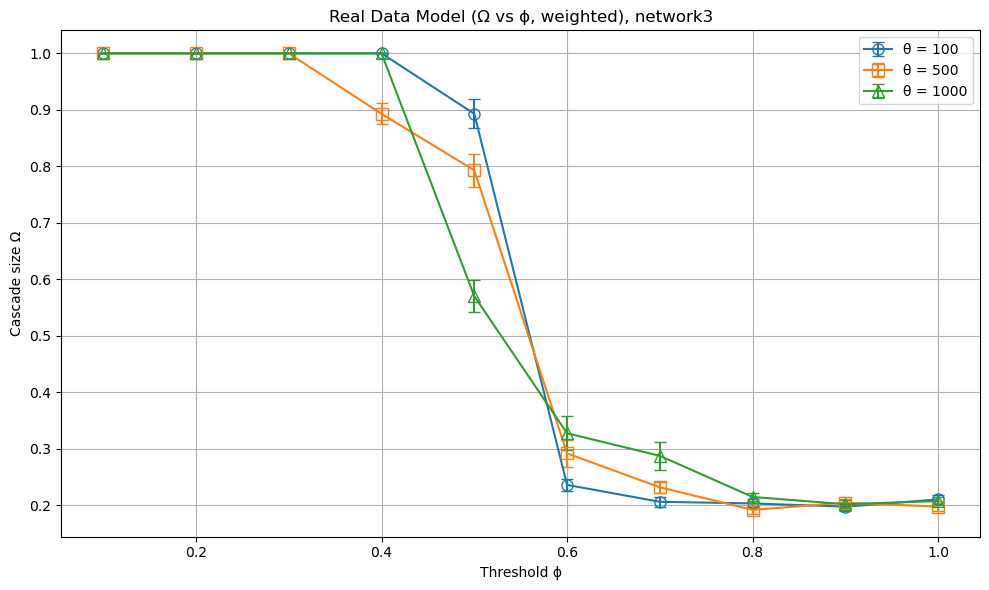

In [8]:
theta_values = [100, 500, 1000]
phi_values = np.round(np.linspace(0.1, 1.0, 10), 2)
repeats = 100
fig2_weighted_results = {}

for net_name, df in temporal_edge_lists.items():
    
    
    real_dict = build_contact_dict(df)
    N = len(set(df["source"]) | set(df["target"]))
    theta_result = {}

    for theta in theta_values:
        real_means, real_se = [], []
        for phi in phi_values:
            vals = [
                simulate_weighted_threshold(
                    real_dict, theta, phi, random.choice(list(real_dict.keys())), N
                )
                for _ in range(repeats)
            ]
            real_means.append(np.mean(vals))
            real_se.append(np.std(vals) / np.sqrt(repeats))
        theta_result[theta] = {"real_mean": real_means, "real_se": real_se}

    fig2_weighted_results[net_name] = theta_result


for net_name, theta_data in fig2_weighted_results.items():
    plt.figure(figsize=(10, 6))
    for i, theta in enumerate(theta_values):
        result = theta_data[theta]
        plt.errorbar(
            phi_values, result["real_mean"], yerr=result["real_se"],
            fmt=['o', 's', '^', 'D'][i] + '-', markersize=8,
            markerfacecolor='none',
            markeredgecolor=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'][i],
            color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'][i],
            capsize=4, label=f"θ = {theta}"
        )
    plt.xlabel("Threshold ϕ")
    plt.ylabel("Cascade size Ω")
    plt.title(f"Real Data Model (Ω vs ϕ, weighted), {net_name}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


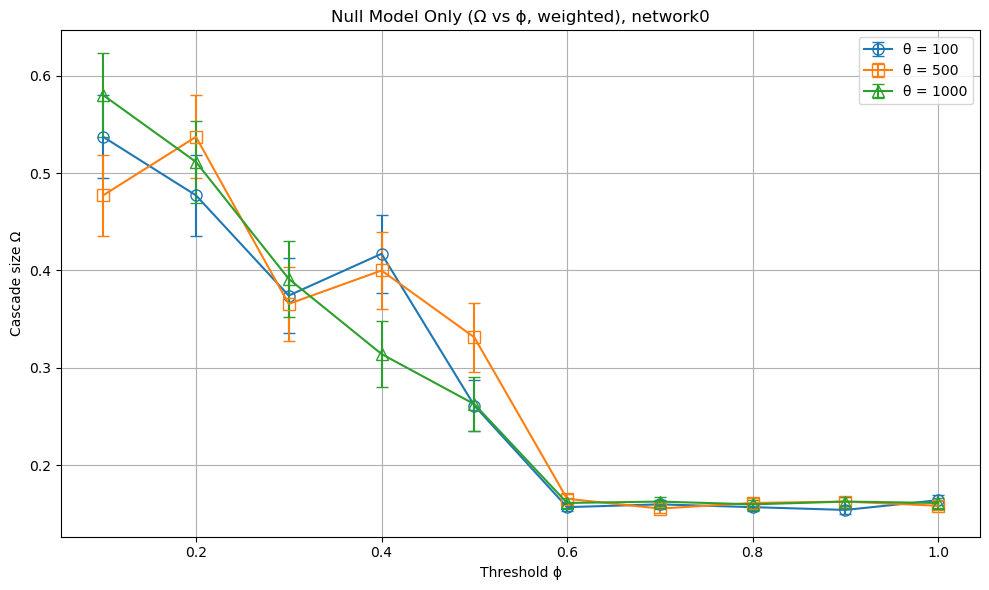

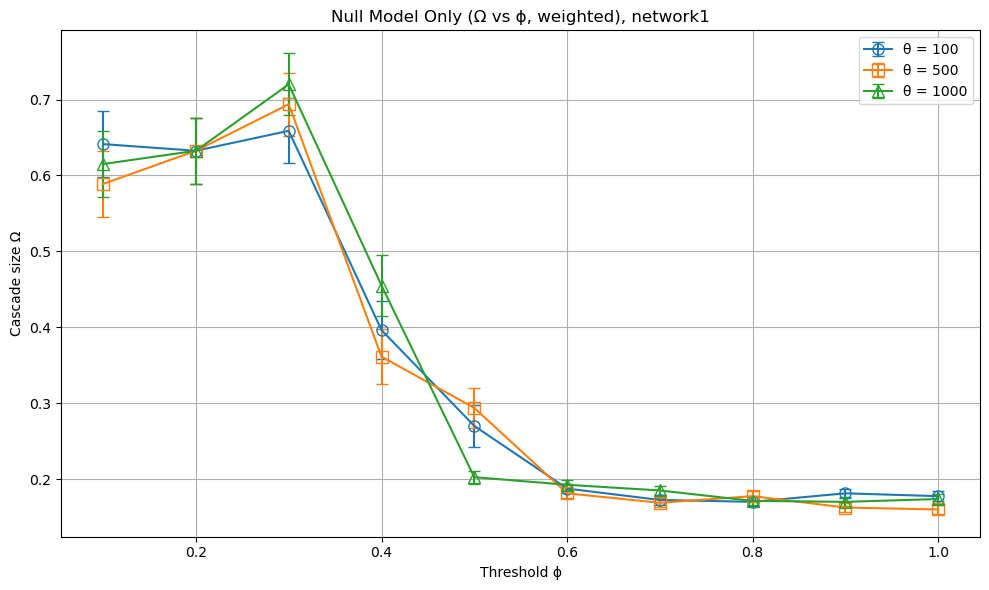

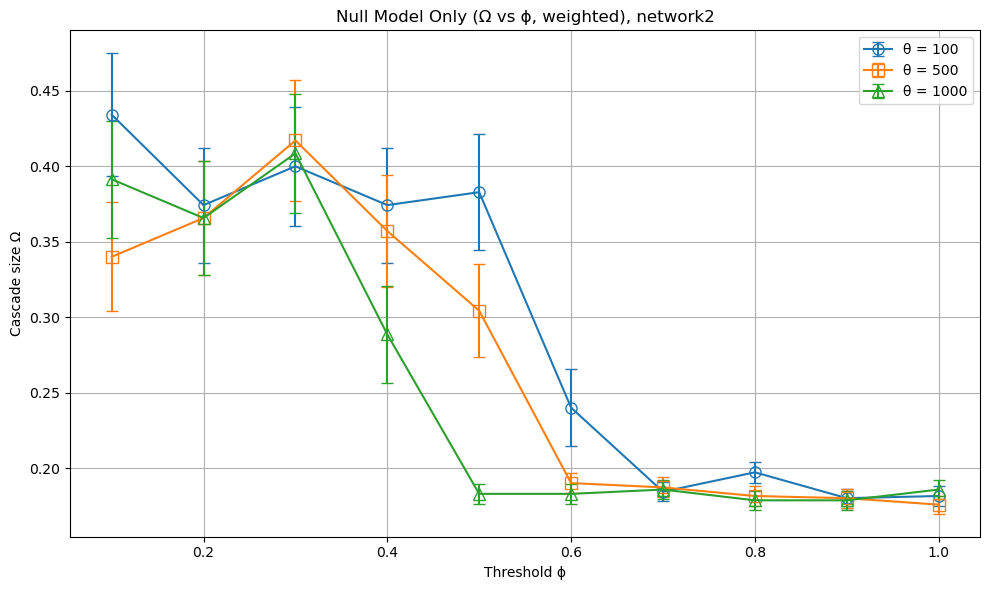

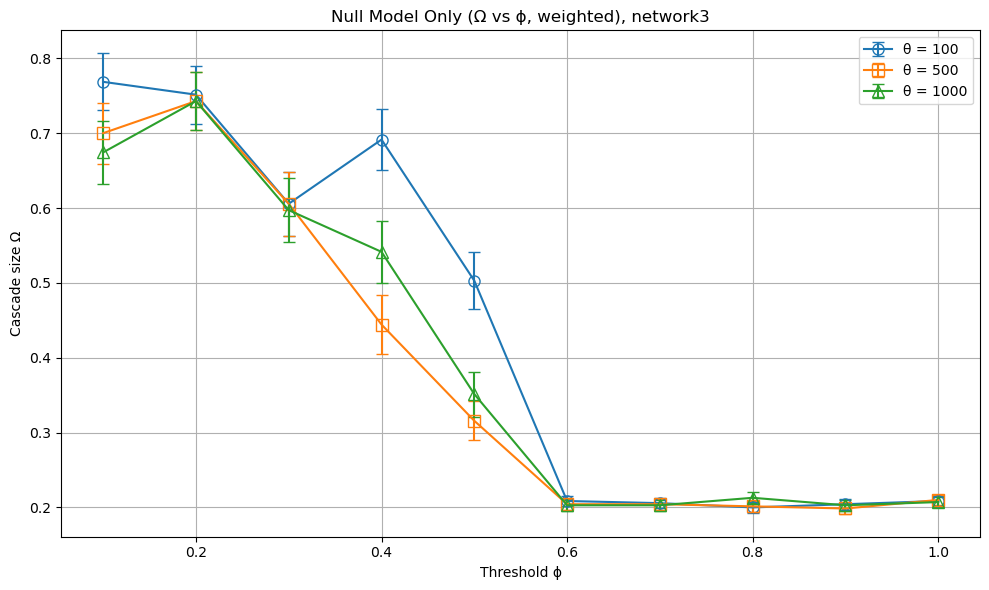

In [9]:
theta_values = [100, 500, 1000]
phi_values = np.round(np.linspace(0.1, 1.0, 10), 2)
repeats = 100
fig2_weighted_results = {}

for net_name, df in temporal_edge_lists.items():
    
    null_dict = build_contact_dict(shuffle_timestamps(df))
    N = len(set(df["source"]) | set(df["target"]))
    theta_result = {}

    for theta in theta_values:
        null_means, null_se = [], []
        for phi in phi_values:
            vals = [
                simulate_weighted_threshold(
                    null_dict, theta, phi, random.choice(list(null_dict.keys())), N
                )
                for _ in range(repeats)
            ]
            null_means.append(np.mean(vals))
            null_se.append(np.std(vals) / np.sqrt(repeats))
        theta_result[theta] = {"null_mean": null_means, "null_se": null_se}

    fig2_weighted_results[net_name] = theta_result


for net_name, theta_data in fig2_weighted_results.items():
    plt.figure(figsize=(10, 6))
    for i, theta in enumerate(theta_values):
        result = theta_data[theta]
        plt.errorbar(
            phi_values, result["null_mean"], yerr=result["null_se"],
            fmt=['o', 's', '^', 'D'][i] + '-', markersize=8,
            markerfacecolor='none', markeredgecolor=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'][i],
            color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'][i],
            capsize=4, label=f"θ = {theta}"
        )
    plt.xlabel("Threshold ϕ")
    plt.ylabel("Cascade size Ω")
    plt.title(f"Null Model Only (Ω vs ϕ, weighted), {net_name}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


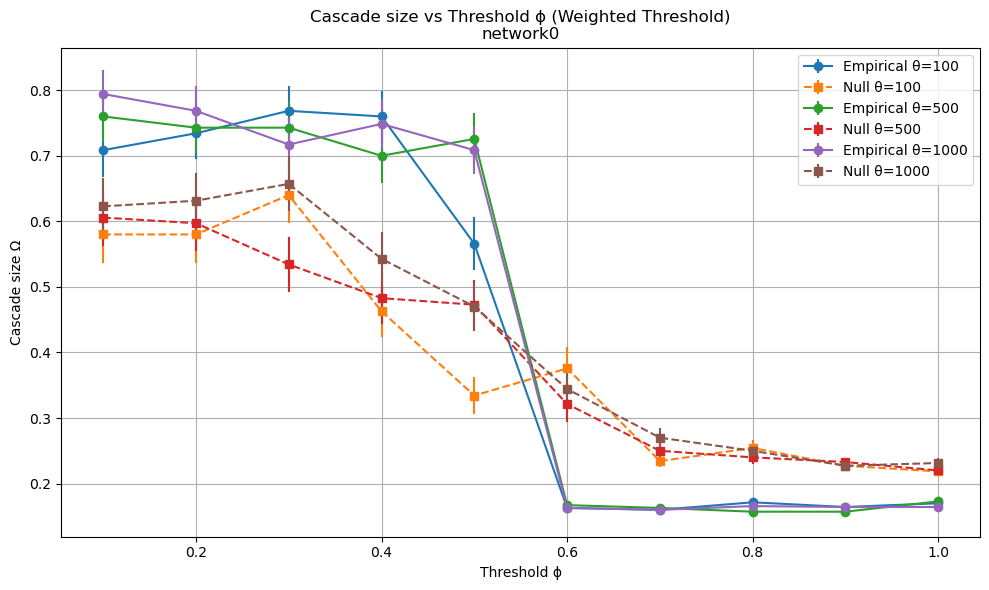

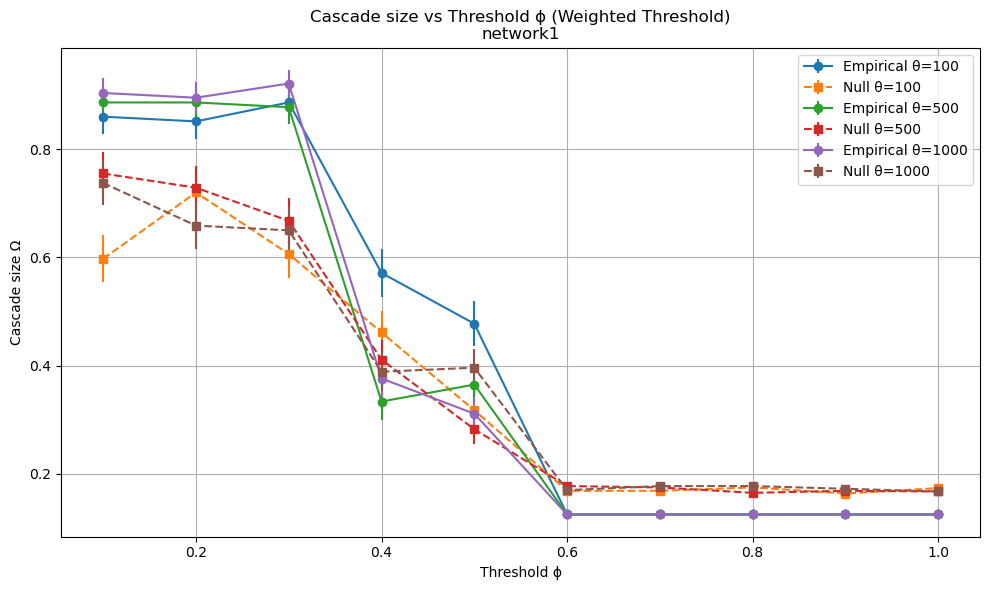

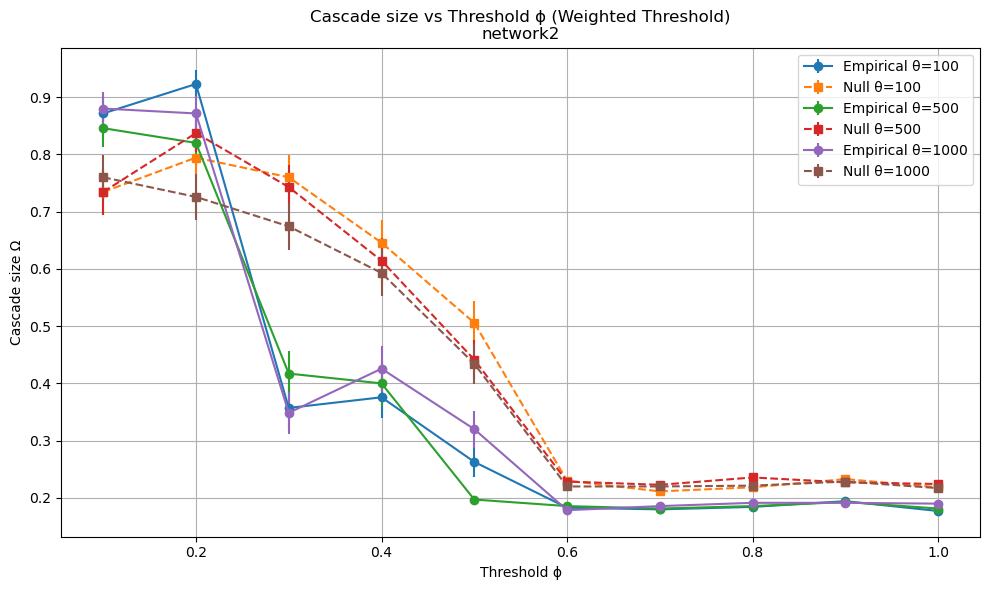

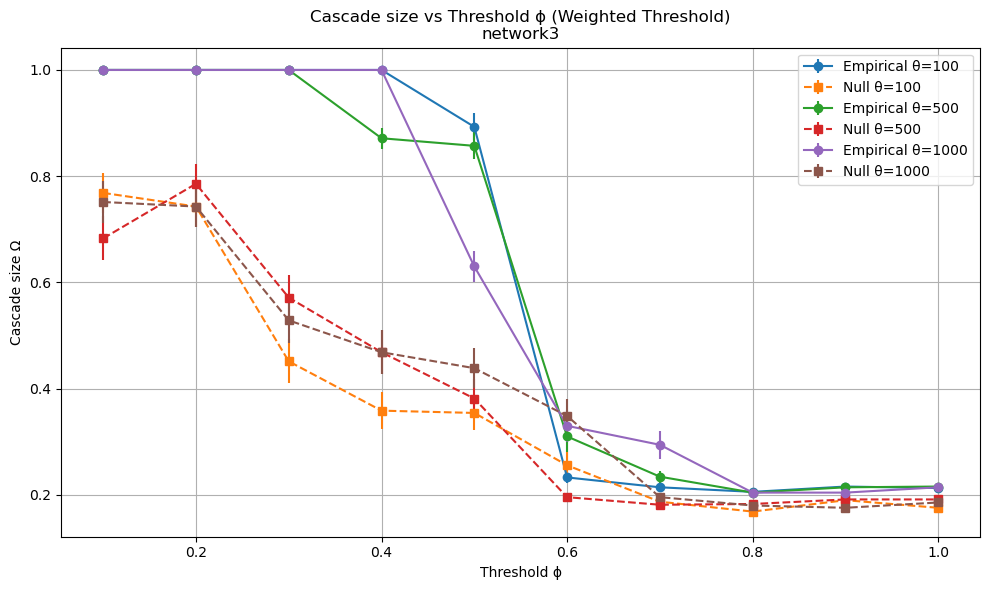

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import random

theta_values = [100, 500, 1000]  
phi_values = np.round(np.linspace(0.1, 1.0, 10), 2)
repeats = 100

fig_phi_results = {}

for net_name, df in temporal_edge_lists.items():
    emp_dict = build_contact_dict(df)
    null_dict = build_contact_dict(shuffle_timestamps(df))
    N = len(set(df["source"]) | set(df["target"]))
    
    theta_result = {}
    
    for theta in theta_values:
        emp_means, emp_se = [], []
        null_means, null_se = [], []
        
        for phi in phi_values:
            emp_vals = [simulate_weighted_threshold(emp_dict, theta, phi, random.choice(list(emp_dict.keys())), N)
                        for _ in range(repeats)]
            null_vals = [simulate_weighted_threshold(null_dict, theta, phi, random.choice(list(null_dict.keys())), N)
                         for _ in range(repeats)]
            
            emp_means.append(np.mean(emp_vals))
            emp_se.append(np.std(emp_vals) / np.sqrt(repeats))
            null_means.append(np.mean(null_vals))
            null_se.append(np.std(null_vals) / np.sqrt(repeats))
        
        theta_result[theta] = {
            "phi": phi_values,
            "emp_mean": emp_means, "emp_se": emp_se,
            "null_mean": null_means, "null_se": null_se
        }
    
    fig_phi_results[net_name] = theta_result


for net_name, theta_data in fig_phi_results.items():
    plt.figure(figsize=(10, 6))
    for i, theta in enumerate(theta_values):
        data = theta_data[theta]
        plt.errorbar(data["phi"], data["emp_mean"], yerr=data["emp_se"],
                     fmt='o-', label=f"Empirical θ={theta}", markersize=6)
        plt.errorbar(data["phi"], data["null_mean"], yerr=data["null_se"],
                     fmt='s--', label=f"Null θ={theta}", markersize=6)
    plt.xlabel("Threshold ϕ")
    plt.ylabel("Cascade size Ω")
    plt.title(f"Cascade size vs Threshold ϕ (Weighted Threshold)\n{net_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


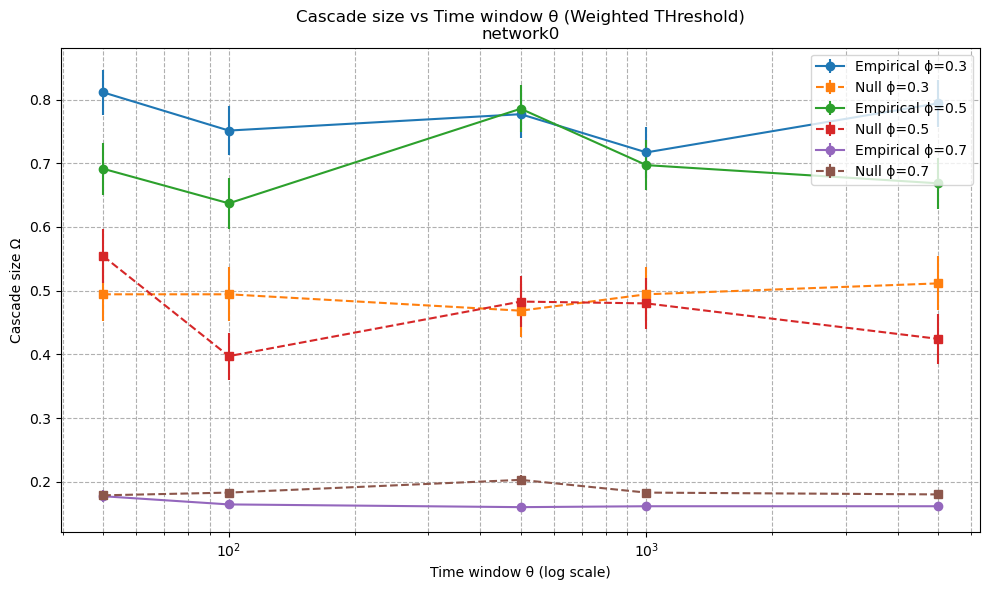

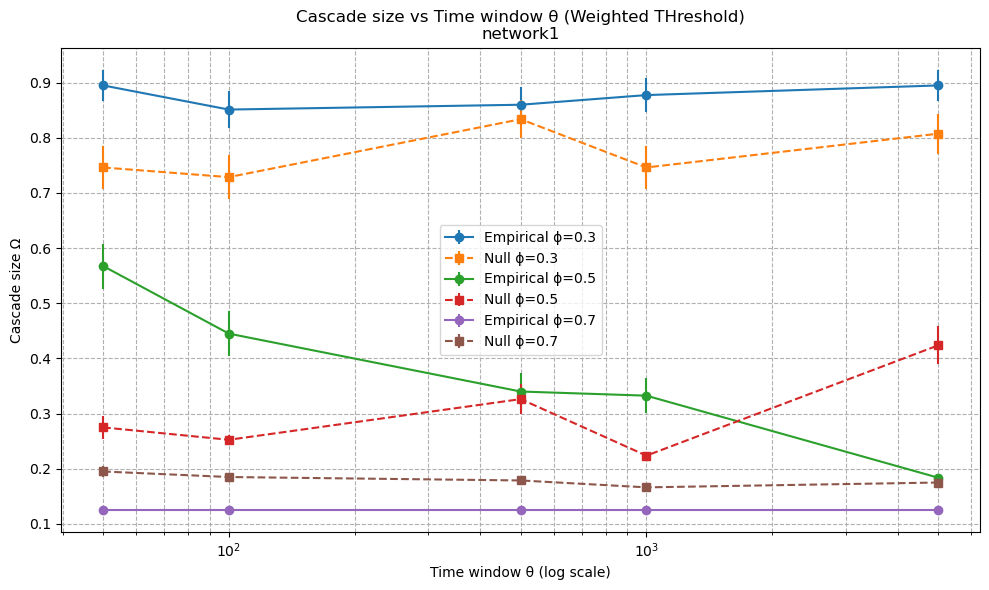

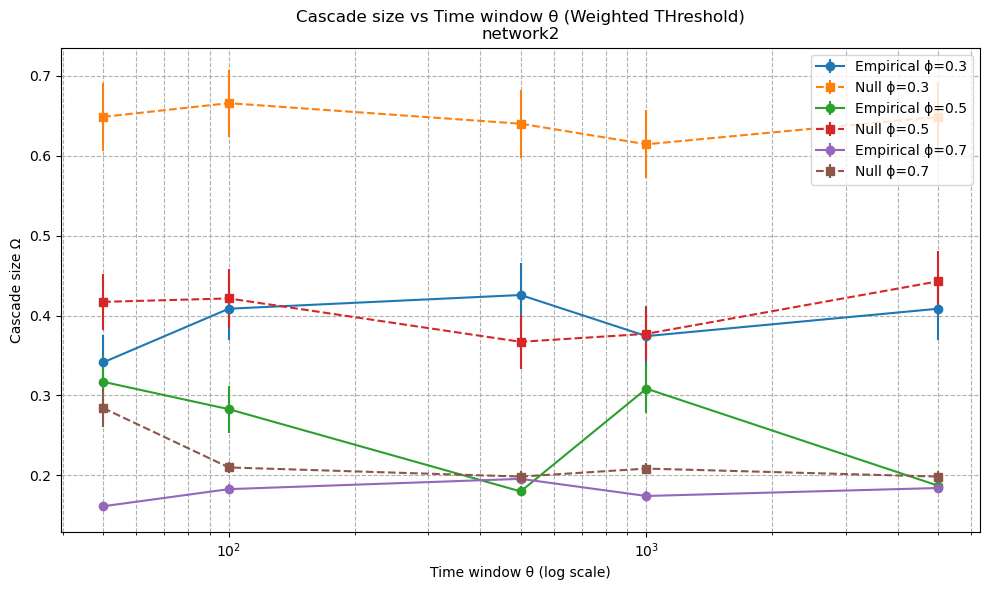

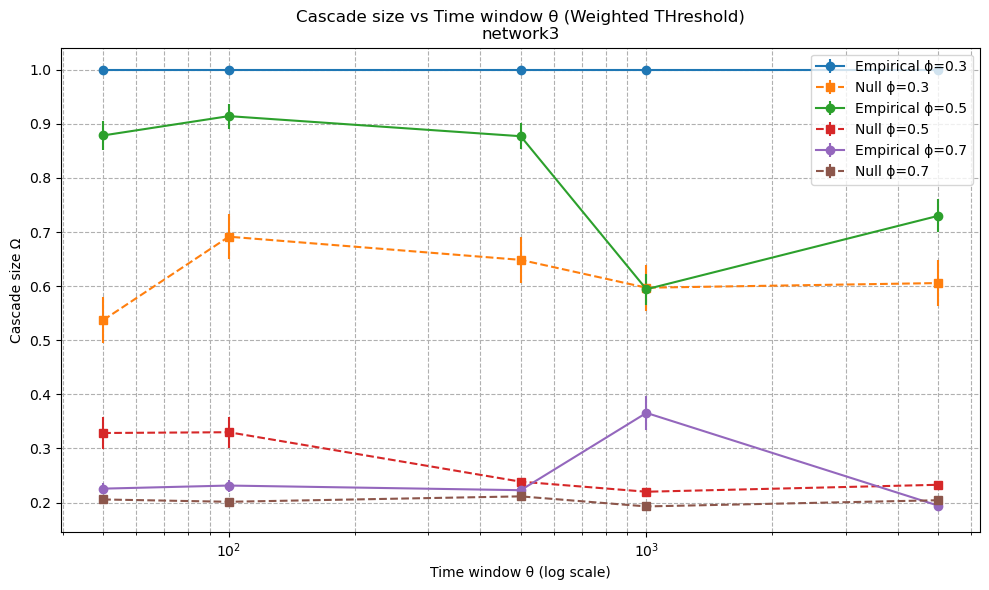

In [11]:
theta_values = np.array([50, 100, 500, 1000, 5000])
phi_values = [0.3, 0.5, 0.7]  
repeats = 100

fig_theta_results = {}

for net_name, df in temporal_edge_lists.items():
    emp_dict = build_contact_dict(df)
    null_dict = build_contact_dict(shuffle_timestamps(df))
    N = len(set(df["source"]) | set(df["target"]))
    
    phi_result = {}
    
    for phi in phi_values:
        emp_means, emp_se = [], []
        null_means, null_se = [], []
        
        for theta in theta_values:
            emp_vals = [simulate_weighted_threshold(emp_dict, theta, phi, random.choice(list(emp_dict.keys())), N)
                        for _ in range(repeats)]
            null_vals = [simulate_weighted_threshold(null_dict, theta, phi, random.choice(list(null_dict.keys())), N)
                         for _ in range(repeats)]
            
            emp_means.append(np.mean(emp_vals))
            emp_se.append(np.std(emp_vals) / np.sqrt(repeats))
            null_means.append(np.mean(null_vals))
            null_se.append(np.std(null_vals) / np.sqrt(repeats))
        
        phi_result[phi] = {
            "theta": theta_values,
            "emp_mean": emp_means, "emp_se": emp_se,
            "null_mean": null_means, "null_se": null_se
        }
    
    fig_theta_results[net_name] = phi_result


for net_name, phi_data in fig_theta_results.items():
    plt.figure(figsize=(10, 6))
    for i, phi in enumerate(phi_values):
        data = phi_data[phi]
        plt.errorbar(data["theta"], data["emp_mean"], yerr=data["emp_se"],
                     fmt='o-', label=f"Empirical ϕ={phi}", markersize=6)
        plt.errorbar(data["theta"], data["null_mean"], yerr=data["null_se"],
                     fmt='s--', label=f"Null ϕ={phi}", markersize=6)
    plt.xscale("log")
    plt.xlabel("Time window θ (log scale)")
    plt.ylabel("Cascade size Ω")
    plt.title(f"Cascade size vs Time window θ (Weighted THreshold)\n{net_name}")
    plt.legend()
    plt.grid(True, which="both", ls='--')
    plt.tight_layout()
    plt.show()
